In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import category_encoders as ce

# Ordinal Mapping with NaN

Ordinal mapping tidak bisa digabung dengan simple imputer dalam pipeline, karena output dari simple imputer berupa array, sedangkan ordinal encoder memerlukan format series/dataframe dengan nama kolom.  

Untuk menyiasati, kita bisa langsung saja menentukan pada kategori berapa NaN akan dimasukkan.

In [4]:
df=pd.DataFrame({'data':['a','b','b',np.nan,'c','a','b']})

In [5]:
df

,data
0,a
1,b
2,b
3,NaN
4,c
5,a
6,b


In [7]:
df.mode()

,data
0,b


In [8]:
ordinal_mapping = [
    {
        'col' : 'data',
        'mapping' : {np.nan : 2, 'a' : 1, 'b' : 2, 'c' : 3} # angka untuk NaN disamakan dengan kategori b
        }
    ]
ce.OrdinalEncoder(mapping=ordinal_mapping).fit_transform(df)

,data
0,1
1,2
2,2
3,2
4,3
5,1
6,2


# Handing Imbalance Classification

## 1. Feature Engineering

In [29]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline

In [13]:
wine= pd.read_csv('white_wine.csv')
wine

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6.0
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6.0
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6.0
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6.0
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...
515,6.1,0.31,0.26,2.2,0.051,28.0,167.0,0.9926,3.37,0.47,10.4,6.0
516,6.8,0.18,0.37,1.6,0.055,47.0,154.0,0.9934,3.08,0.45,9.1,5.0
517,7.4,0.15,0.42,1.7,0.045,49.0,154.0,0.9920,3.00,0.60,10.4,6.0
518,5.9,0.13,0.28,1.9,0.050,20.0,78.0,0.9918,3.43,0.64,10.8,6.0


### EDA

* Good wine, quality >6
* Bad wine, quality <=6

In [15]:
wine.isna().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      1
sulphates               1
alcohol                 1
quality                 1
dtype: int64

In [16]:
wine['alcohol'].fillna(wine['alcohol'].mean(), inplace=True)
wine['label']= np.where(wine['quality']>6,1,0)
wine['label'].value_counts()/wine.shape[0]*100

0    81.153846
1    18.846154
Name: label, dtype: float64

Dataset imbalance, karena kelas 0 jauh lebih banyak dibanding kelas 1

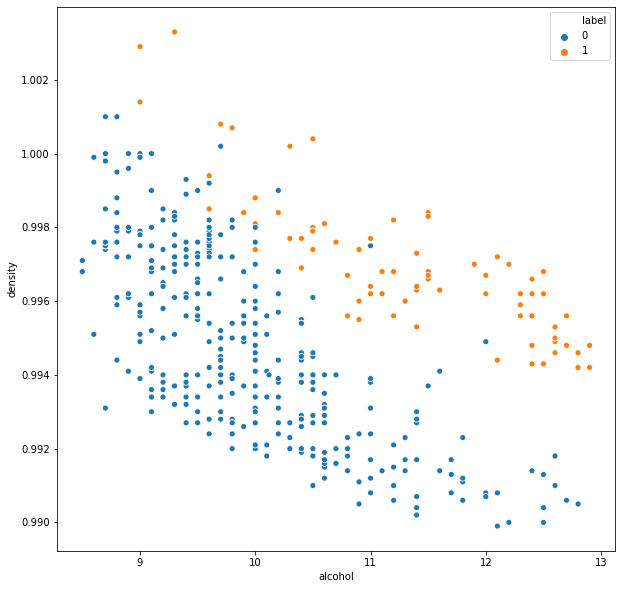

In [17]:
plt.figure(figsize=(10,10))
sns.scatterplot(x='alcohol', y='density', data=wine, hue='label')

### Data Splitting

In [18]:
X=wine[['density','alcohol']]
y=wine['label']

In [19]:
X_train, X_test, y_train,y_test= train_test_split(X,y, stratify=y, random_state=2020)

### Without Polynomial

In [21]:
logreg=LogisticRegression()
logreg.fit(X_train,y_train)

LogisticRegression()

In [22]:
y_pred=logreg.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.87      0.96      0.91       106
           1       0.69      0.38      0.49        24

    accuracy                           0.85       130
   macro avg       0.78      0.67      0.70       130
weighted avg       0.84      0.85      0.84       130



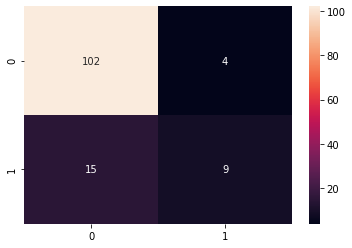

In [25]:
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True, fmt='g')

In [26]:
### With Polynomial

In [30]:
poly=PolynomialFeatures(degree=3, interaction_only=False, include_bias=False)
logreg= LogisticRegression()

pipe_logreg=Pipeline([
    ('poly',poly),
    ('logreg',logreg)])

In [31]:
pipe_logreg.fit(X_train,y_train)

C:\Users\brigi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('poly', PolynomialFeatures(degree=3, include_bias=False)),
                ('logreg', LogisticRegression())])

In [32]:
y_pred= pipe_logreg.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       106
           1       0.95      0.88      0.91        24

    accuracy                           0.97       130
   macro avg       0.96      0.93      0.95       130
weighted avg       0.97      0.97      0.97       130



Text(33.0, 0.5, 'actual')

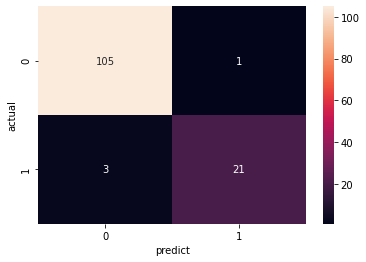

In [34]:
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True, fmt='g')
plt.xlabel('predict')
plt.ylabel('actual')

In [ ]:
Dari percobaan di atas, kita bisa melihat bahwa penggunaan feature engineering, dalam hal ini polynomial, mampu meningkatkan performa model:  
* Precision(+): 0.69 --> 0.95  
* Recall(+): 0.38 --> 0.88
* f1 score(+): 0.49 --> 0.91
* FN: 15 --> 3
* TP: 9 --> 21


## 2. Resampling Method

In [37]:
!pip install imblearn

In [52]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from imblearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import plot_roc_curve, classification_report, f1_score

In [41]:
 bankloan = pd.read_csv('bankloan.csv')

In [42]:
bankloan.head()

,age,ed,employ,address,income,debtinc,creddebt,othdebt,default
0,41,3,17,12,176,9.3,11.359392,5.008608,1
1,27,1,10,6,31,17.3,1.362202,4.000798,0
2,40,1,15,14,55,5.5,0.856075,2.168925,0
3,41,1,15,14,120,2.9,2.658720,0.821280,0
4,24,2,2,0,28,17.3,1.787436,3.056564,1


* Target: default
* features: employ, debtinc, creddebt, othdebt

In [43]:
X= bankloan[['employ','debtinc','creddebt','othdebt']]
y=bankloan['default']

### EDA

In [46]:
bankloan['default'].value_counts()/bankloan.shape[0]*100

0    73.857143
1    26.142857
Name: default, dtype: float64

Data imbalance:  
* kelas not default = 73.86%  
* kelas default= 26.14%

### Data Splitting

In [107]:
X_train_val, X_test, y_train_val, y_test= train_test_split( 
    X,y,
    stratify=y,
    test_size=0.2, 
    random_state= 1899)

#### Benchmark

In [108]:
model= LogisticRegression()
model.fit(X_train_val,y_train_val)

LogisticRegression()

In [109]:
y_pred=model.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.81      0.93      0.87       103
           1       0.68      0.41      0.51        37

    accuracy                           0.79       140
   macro avg       0.75      0.67      0.69       140
weighted avg       0.78      0.79      0.77       140



#### Resampling: UnderSampling

In [110]:
rus= RandomUnderSampler(random_state=2020)
X_under, y_under=rus.fit_resample(X_train_val,y_train_val)

In [111]:
y_train_val.value_counts()

0    414
1    146
Name: default, dtype: int64

In [112]:
y_under.value_counts()

1    146
0    146
Name: default, dtype: int64

In [113]:
model_under= LogisticRegression()
model_under.fit(X_under,y_under)
y_pred=model_under.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.96      0.71      0.82       103
           1       0.53      0.92      0.67        37

    accuracy                           0.76       140
   macro avg       0.75      0.81      0.74       140
weighted avg       0.85      0.76      0.78       140



Dengan menggunakan undersampling:
* Precision turun dari 0.75 menjadi 0.56
* Recall naik dari 0.54 menjadi 0.90 (ada trade off antara precision dan recall)
* f1 score naik sedikit dari 0.63 menjadi 0.69

Tugas: Coba gunakan resampling oversampler

In [114]:
ros= RandomOverSampler(random_state=2020)
X_over, y_over=ros.fit_resample(X_train_val,y_train_val)

In [115]:
y_over.value_counts()

1    414
0    414
Name: default, dtype: int64

In [116]:
model_over= LogisticRegression()
model_over.fit(X_over,y_over)
y_pred=model_over.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.95      0.73      0.82       103
           1       0.54      0.89      0.67        37

    accuracy                           0.77       140
   macro avg       0.75      0.81      0.75       140
weighted avg       0.84      0.77      0.78       140



## 3. Threshold Optimization

In [117]:
model= LogisticRegression()
model.fit(X_train_val,y_train_val)
y_pred=model.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.81      0.93      0.87       103
           1       0.68      0.41      0.51        37

    accuracy                           0.79       140
   macro avg       0.75      0.67      0.69       140
weighted avg       0.78      0.79      0.77       140



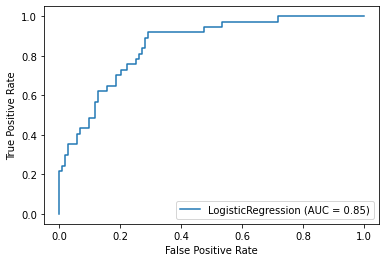

In [118]:
plot_roc_curve(model, X_test,y_test)

In [119]:
# Khusus threshold optimization, karena optimisasi dilakukan manual

X_train, X_val, y_train, y_val= train_test_split(
    X_train_val,y_train_val, 
    stratify= y_train_val,
    test_size= 0.25, # atau 20% dari dataset utuh
    random_state= 1899
)

In [120]:
model.fit(X_train,y_train)

th_value=[i/100 for i in range(20,60)]
score=0
score_list=[]


In [121]:
for i in th_value:
    y_prob= model.predict_proba(X_val)[:,1]
    y_pred= np.where(y_prob>i,1,0)
    score_temp=f1_score(y_val,y_pred)
    score_list.append(score_temp)

    if score_temp> score:
        score=score_temp
        best_th=i

In [122]:
best_th

0.47

In [123]:
pd.DataFrame({'threshold': th_value, 'score':score_list})

,threshold,score
0,0.20,0.625000
1,0.21,0.630631
2,0.22,0.641509
3,0.23,0.634615
4,0.24,0.647059
5,0.25,0.647059
6,0.26,0.620000
7,0.27,0.632653
8,0.28,0.645833
9,0.29,0.631579


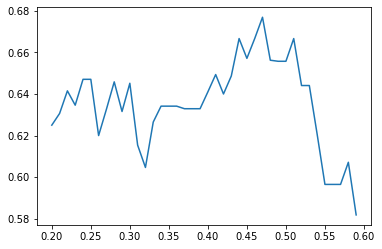

In [124]:
sns.lineplot(th_value,score_list)

In [129]:
model.fit(X_train_val,y_train_val)
y_prob= model.predict_proba(X_test)[:,1]
y_pred=np.where(y_prob>best_th,1,0)

In [130]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.82      0.90      0.86       103
           1       0.62      0.43      0.51        37

    accuracy                           0.78       140
   macro avg       0.72      0.67      0.68       140
weighted avg       0.76      0.78      0.76       140



## 4. Penalty (algorithm based)

In [132]:
model_balanced= LogisticRegression(class_weight='balanced')
model_balanced.fit(X_train_val,y_train_val)
y_pred=model_balanced.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.95      0.72      0.82       103
           1       0.53      0.89      0.67        37

    accuracy                           0.76       140
   macro avg       0.74      0.81      0.74       140
weighted avg       0.84      0.76      0.78       140



## Summary

In [135]:
f1_bm= f1_score(y_test, model.predict(X_test))

y_proba= model.predict_proba(X_test)[:,1]
y_pred_th= np.where(y_proba>best_th,1,0)
f1_th=f1_score(y_test,y_pred_th)

f1_under= f1_score(y_test,model_under.predict(X_test))
f1_over=f1_score(y_test,model_over.predict(X_test))
f1_bal= f1_score(y_test, model_balanced.predict(X_test))

In [136]:
score_list= [f1_bm, f1_th, f1_under,f1_over, f1_bal]
model_name=['benchmark','threshold','undersampler','oversampler','algo based']
df_sum= pd.DataFrame({
    'method': model_name,
    'score':score_list
})
df_sum

,method,score
0,benchmark,0.508475
1,threshold,0.507937
2,undersampler,0.673267
3,oversampler,0.673469
4,algo based,0.666667


Untuk dataset ini, berdasarkan f1-score, bisa dilihat bahwa, random oversampling/ random undersampling memiliki performa terbaik untuk menangani data imbalance.

kalian bisa mencoba metode lain dan mengoptimisasi metode yang sudah kita coba melalui hyperparameter tunning